In [103]:
import pandas as pd
import numpy as np
import nltk as nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import *
from nltk.corpus import *
from sklearn.model_selection import train_test_split


In [104]:
data = pd.read_csv('/kaggle/input/dataragel/train.csv')
print(data.head())

   SampleID                                         Discussion  Category
0         1  Without sitting down and doing it manually, yo...    Sports
1         2               All your Search ends with this link.      STEM
2         3  No, the program you're using is made to be com...      STEM
3         4  Mike Woicik\n\nThe correct answer is: Mike Woi...    Sports
4         5  No, but not because of why you might think. Wh...  Politics


In [105]:
category_mapping = {'Politics': 0, 'Sports': 1, 'Media': 2, 'Market & Economy': 3, 'STEM': 4}
data['Category'] = data['Category'].replace(category_mapping)
print(data['Category'].head())

0    1
1    4
2    4
3    1
4    0
Name: Category, dtype: int64


In [106]:
def drop_1st_col(df):
    df.drop(columns=['SampleID'], inplace=True)
    return df
print(data.head())
data = drop_1st_col(data)

   SampleID                                         Discussion  Category
0         1  Without sitting down and doing it manually, yo...         1
1         2               All your Search ends with this link.         4
2         3  No, the program you're using is made to be com...         4
3         4  Mike Woicik\n\nThe correct answer is: Mike Woi...         1
4         5  No, but not because of why you might think. Wh...         0


In [107]:
def drop_nulls(df):
    print(df.isnull().sum())
    df.dropna(subset=['Discussion'], inplace=True)
    print(df.isnull().sum())
    return df
data = drop_nulls(data)

Discussion    343
Category        0
dtype: int64
Discussion    0
Category      0
dtype: int64


In [108]:
def to_lowercase(df):
    df['Discussion'] = df['Discussion'].str.lower()
    return df
data = to_lowercase(data)

In [109]:
def count_duplicates_by_columns(df, columns):
    num_duplicates = df.duplicated(subset=columns).sum()
    print(f'num_duplicates = {num_duplicates}, columns = {columns}')

In [110]:
def remove_duplicates(df):
    df = df.drop_duplicates(subset=['Discussion', 'Category'])
    df = df[df['Discussion'].map(df['Discussion'].value_counts()) == 1]
    return df
data = remove_duplicates(data)
count_duplicates_by_columns(data, ['Discussion', 'Category'])

num_duplicates = 0, columns = ['Discussion', 'Category']


In [111]:
def clean(df):
    df['Discussion'] = df['Discussion'].replace({r'\\n': ' '}, regex=True)

    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    df = df.applymap(lambda x: re.sub(url_pattern, '', str(x)) if isinstance(x, str) else x)

    df['Discussion'] = df['Discussion'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    df['Discussion'] = df['Discussion'].apply(lambda x: re.sub(r'\s+', ' ', x))  

    df['Discussion'] = df['Discussion'].apply(lambda x: x.strip())  

    return df

data = clean(data)

<ipython-input-111-b7101363bfce>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(url_pattern, '', str(x)) if isinstance(x, str) else x)


In [112]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]  
    return ' '.join(words)

data['Discussion'] = data['Discussion'].apply(clean_text)

print(data.head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                          Discussion  Category
0  without sitting manually might try scheduling ...         1
1                                   search ends link         4
2  program youre using made compatible dvdrom dri...         4
3  mike woicik correct answer mike woicik super b...         1
4  might think profile something tend miss dont f...         0


In [113]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def split_data(df):
    df = shuffle(df, random_state=42)

    X_train, X_val, Y_train, Y_val = train_test_split(
        df['Discussion'], df['Category'],
        test_size=0.2,
        random_state=42,
        stratify=df['Category']
    )

    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = split_data(data)

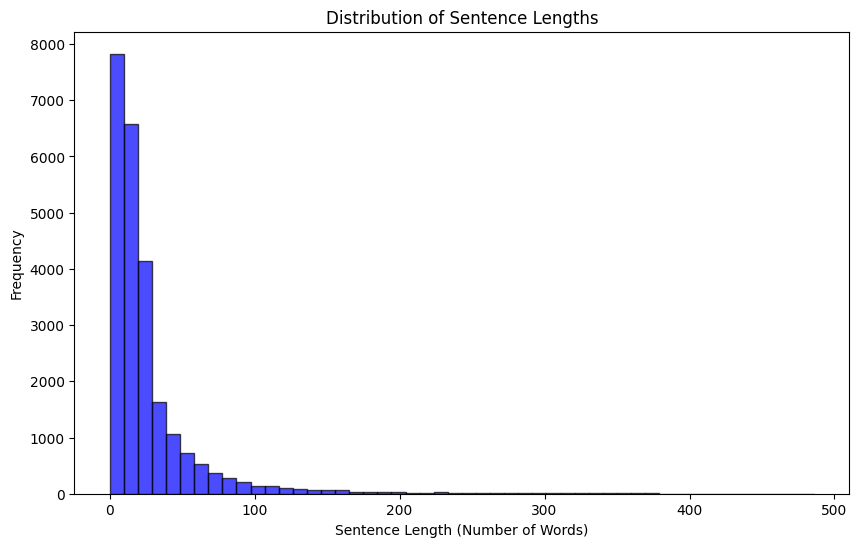

In [114]:
data['text_length'] = data['Discussion'].apply(lambda x: len(x.split()))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.show()


In [115]:
max_sequence_length = int(data['text_length'].quantile(0.95))
print(f"MAX_SEQUENCE_LENGTH: {max_sequence_length}")


MAX_SEQUENCE_LENGTH: 90


In [116]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Add, Attention, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.layers import Input, Add
from keras.regularizers import l2
from tensorflow.keras.models import load_model


max_vocab_size = 10000  
max_sequence_length = 100  

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")  
tokenizer.fit_on_texts(X_train)  

X_train_sequences = tokenizer.texts_to_sequences(X_train)  
X_val_sequences = tokenizer.texts_to_sequences(X_val)  
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')  # Pad training sequences
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')  # Pad validation sequences

Y_train = np.array(Y_train)  
Y_val = np.array(Y_val)  

embedding_dim = 200  
embedding_index = {}
glove_file_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt' 

with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix for the tokenizer
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


inputs = Input(shape=(max_sequence_length,))

x = Embedding(input_dim=max_vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_sequence_length, 
              trainable=True)(inputs)  
x = Dropout(0.3)(x)  

x = Conv1D(filters=128, kernel_size=3, activation='tanh', kernel_regularizer=l2(0.004))(x)
x = BatchNormalization()(x)  

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.004)))(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='tanh', kernel_regularizer=l2(0.004))(x)
x = Dropout(0.6)(x)  


x = Dense(128, activation='tanh', kernel_regularizer=l2(0.004))(x)
x = Dropout(0.5)(x)  


x = Dense(32, activation='tanh', kernel_regularizer=l2(0.004))(x)
x = Dropout(0.3)(x)

outputs = Dense(len(category_mapping), activation='softmax')(x)


model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']  
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=4,  
    restore_best_weights=True,  
    verbose=1  
)

# Display Model Summary
print(model.summary())

# Train the Model with EarlyStopping callback
history = model.fit(
    X_train_padded, Y_train,
    validation_data=(X_val_padded, Y_val),  # Validation data
    epochs=30,  # Number of epochs
    batch_size=8,  # Batch size
    verbose=1,  # Print progress
    callbacks=[early_stopping]  # Add EarlyStopping callback
)

model.save("trained_cnn_lstm1_glove.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 100, 200)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 100, 200)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 98, 128)             │          76,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 98, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312,261 (8.82 MB)

 Trainable params: 2,312,005 (8.82 MB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.2691 - loss: 5.2735 - val_accuracy: 0.5598 - val_loss: 4.2354
Epoch 2/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.4896 - loss: 4.2072 - val_accuracy: 0.6443 - val_loss: 3.4431
Epoch 3/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.5883 - loss: 3.4523 - val_accuracy: 0.6708 - val_loss: 2.9051
Epoch 4/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6298 - loss: 2.9210 - val_accuracy: 0.6781 - val_loss: 2.5186
Epoch 5/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.6611 - loss: 2.5181 - val_accuracy: 0.6810 - val_loss: 2.2298
Epoch 6/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6704 - loss: 2.2094 - val_accuracy: 0.6888 - val_loss: 1.9804
Epoch 7/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6826 - loss: 1.9688 - val_accuracy: 0.6955 - val_loss: 1.7932
Epoch 8/30
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.6

In [117]:

test_data = pd.read_csv('/kaggle/input/dataragel2/test.csv')
test_data = to_lowercase(test_data)
test_data = clean(test_data)
test_data['Discussion'] = test_data['Discussion'].apply(clean_text)

test_sequences = tokenizer.texts_to_sequences(test_data['Discussion'])
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

print(test_data.head())

predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)

reverse_category_mapping = {v: k for k, v in category_mapping.items()}

test_data['Category'] = predicted_classes

output_file = 'predicted_categories1.csv'
test_data[['SampleID', 'Category']].to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


<ipython-input-111-b7101363bfce>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(url_pattern, '', str(x)) if isinstance(x, str) else x)


   SampleID                                         Discussion
0         1  managing cash flow effectively crucial busines...
1         2  civic engagement plays key role democracy allo...
2         3  proper warmups cooldowns essential avoid injur...
3         4  data security growing concern people store per...
4         5  investing stocks risky careful research lead s...
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Predictions saved to predicted_categories1.csv


In [118]:

model.save_weights("model_weights.weights.h5")


In [119]:
from tensorflow.keras.models import save_model

save_model(model, 'my_model.keras')

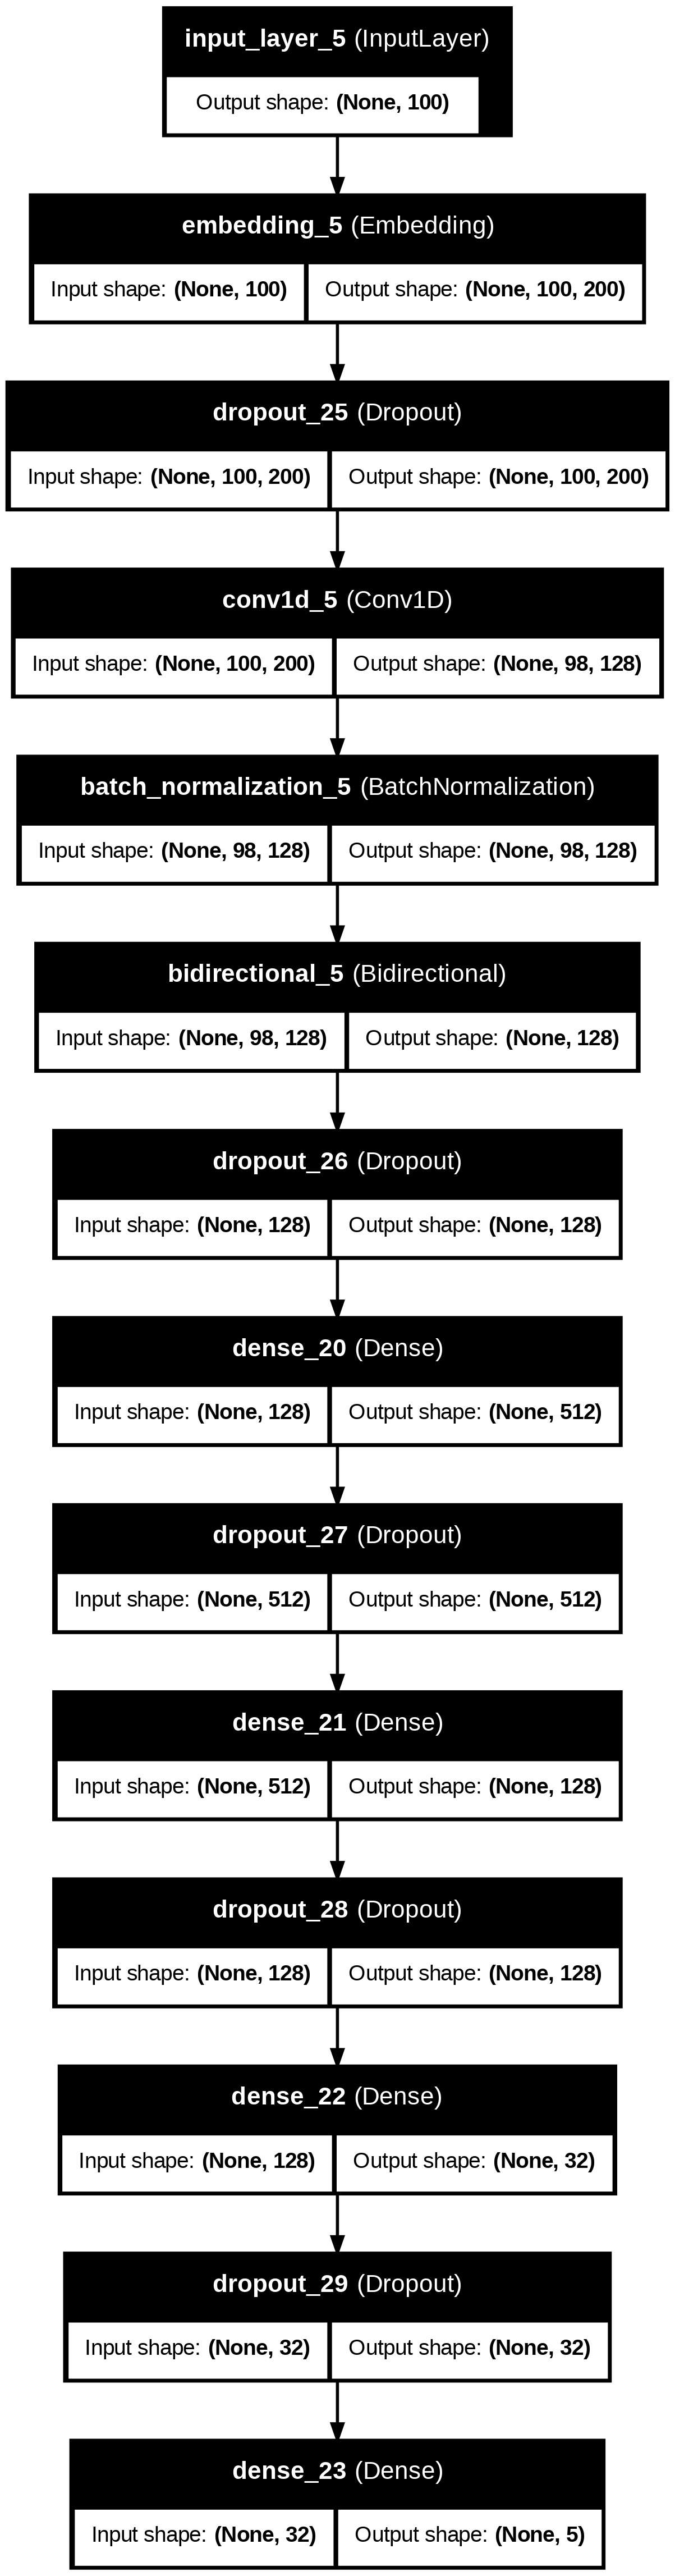

In [120]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)